# Expectation Maximization

In [7]:
%matplotlib inline
from __future__ import division
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interact, FloatSlider

I was checking [this post](http://nipunbatra.github.io/2014/04/em/) from last year about Expectation Maximization and I noticed that the first piece of code did not quite work anymore (some of the classes from `ipywidgets` it used are now gone), so I started checking the rest of the code to see what else I could fix or improve.

First the widget. Not much change here. The decorator makes the code a little bit more elegant:

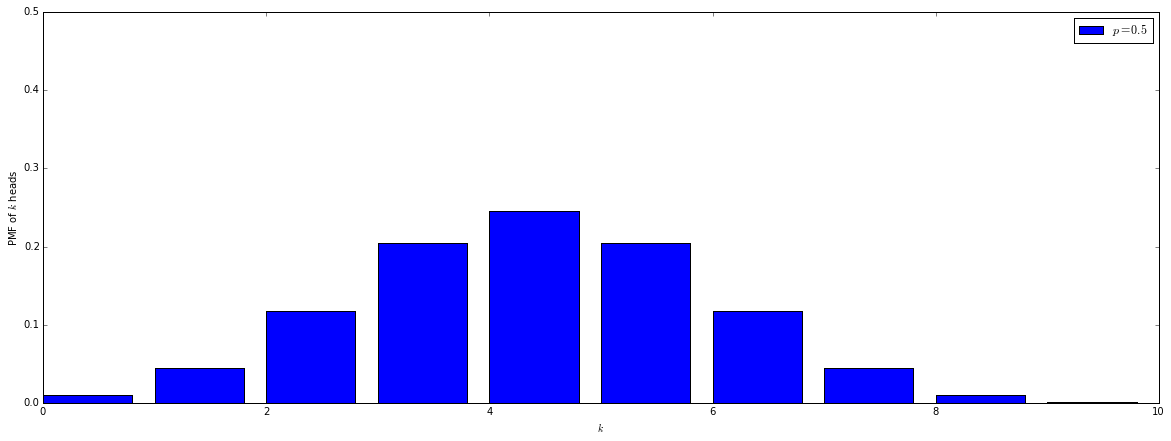

In [8]:
p_slider = FloatSlider(min=0, max=1.0, step=0.1, value=0.5)

@interact(p=p_slider)
def plot_binomial(p=0.5):
    a=range(11)
    fig, ax = plt.subplots(figsize=(20,7))
    y = [0]*11
    for i in a:
        y[i-1] =  stats.binom.pmf(i, 10, p)
    ax.bar(a,y,label="$p = %.1f$" % p)
    ax.set_ylabel('PMF of $k$ heads')
    ax.set_xlabel('$k$')
    ax.set_ylim((0,0.5))
    ax.set_xlim((0,10))
    ax.legend()

The next big chunk of code was the implementation of the EM algorithm itself. I noticed that the code was not using vectorized functions and that (partly because of this) it forced the number of priors to be two. So I refactored it in such a way that it is now able to handle arbitrary number of priors (in case we assume that, for instance, we have tree coins (or seven (or two hundred)) instead of two). This is the resulting version:

In [9]:
def em_single(priors, observations):
    tails = heads = np.zeros(len(priors))

    for observation in observations: 
        len_observation = len(observation)
        num_heads = observation.sum()
        num_tails = len_observation - num_heads
        contributions = stats.binom.pmf(num_heads,len_observation,priors)
        weights = contributions / sum(contributions)
        heads = heads + weights * num_heads
        tails = tails + weights * num_tails 
 
    new_priors = heads / (heads + tails)
    return new_priors

def em(observations, prior, tol=1e-6, iterations=10000):
    for iteration in xrange(iterations):
        new_prior = em_single(prior, observations)
        delta_change = np.abs(prior[0]-new_prior[0])
        if delta_change<tol:
            break
        else:
            prior = new_prior
    return [new_prior, iteration]

What follows now is a function for generating observations given a vector of probabilities for heads, one for each coin, and also the number of trials for each coin.

In [10]:
def obs(p, n=10):
    r = np.random.binomial(n, p)
    output = ([1] * r) + ([0] * (n-r))
    random.shuffle(output)
    return output

def multiple_obs(probs, trials, n=10):
    return np.concatenate([np.array([obs(p, n) for i in range(t)]) for p, t in zip(probs, trials)])

For instance, here we have 30 trials with a coin with probability 0.2 for heads, 33 trials with a fair coin and 32 trials with a coin with probability 0.7 for heads:

In [11]:
observations = multiple_obs([0.2, 0.5, 0.7], [30, 33, 32])
print observations

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 1 0 1 0]
 [0 0 1 0 0 0 0 0 0 0]
 [1 0 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 1]
 [0 1 1 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 1 0]
 [0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 1 0 0 0]
 [0 1 1 1 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 1 1 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 0]
 [1 0 0 0 0 0 0 1 1 1]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 1 1]
 [1 0 1 1 0 1 1 0 1 1]
 [1 0 1 0 0 0 0 0 0 1]
 [0 0 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 0 1 1 0 0 0 1 1]
 [1 1 0 0 1 1 0 1 1 1]
 [0 1 0 0 1 1 0 0 1 1]
 [1 0 0 1 0 0 1 0 0 1]
 [1 1 0 1 1 1 1 1 0 0]
 [0 0 1 0 0 0 1 0 0 1]
 [0 0 0 0 1 1 0 1 1 1]
 [0 0 1 0 0 1 0 1 0 1]
 [1 0 0 1 1 1 0 1 1 0]
 [0 0 1 1 1

Let's now try EM with priors 0.1, 0.2, 0.3: 

In [12]:
em(observations, [0.1, 0.2, 0.3])

[array([ 0.18065851,  0.58346535,  0.59010421]), 91]

Not bad! Next same observations and priors 0.8, 0.85, 0.9:

In [13]:
em(observations, [0.8, 0.85, 0.9])

[array([ 0.18065845,  0.58346002,  0.59010943]), 84]

Another set of observations. Three fair coins. Is EM gonna get confused? 

In [14]:
observations = multiple_obs([0.5, 0.5, 0.5], [30, 33, 32])

In [15]:
em(observations, [0.8, 0.85, 0.9])

[array([ 0.5147204 ,  0.51473283,  0.5147573 ]), 134]

In [16]:
em(observations, [0.4, 0.6, 0.5])

[array([ 0.51472015,  0.51475572,  0.51473466]), 134]

Not as good. And it takes a lot of iterations (in comparison to the previous set of observations) to reach convergence. 

Finally a tiny experiment. If I grow little by little my trial set and run EM always starting with the same priors does the EM predictions improve as the number of trials grows? Most surely, but how fast?

In [27]:
a = []
real_probs = [0.3, 0.5, 0.8]
observations = multiple_obs(real_probs, [20] * 3)
for i in range(100):
    observations = np.concatenate([observations, multiple_obs(real_probs, [1]*3)])
    a.append(sorted(em(observations, [0.1, 0.2, 0.3])[0]))

In [30]:
df = pd.DataFrame(a)
df.columns = ['p1', 'p2', 'p3']

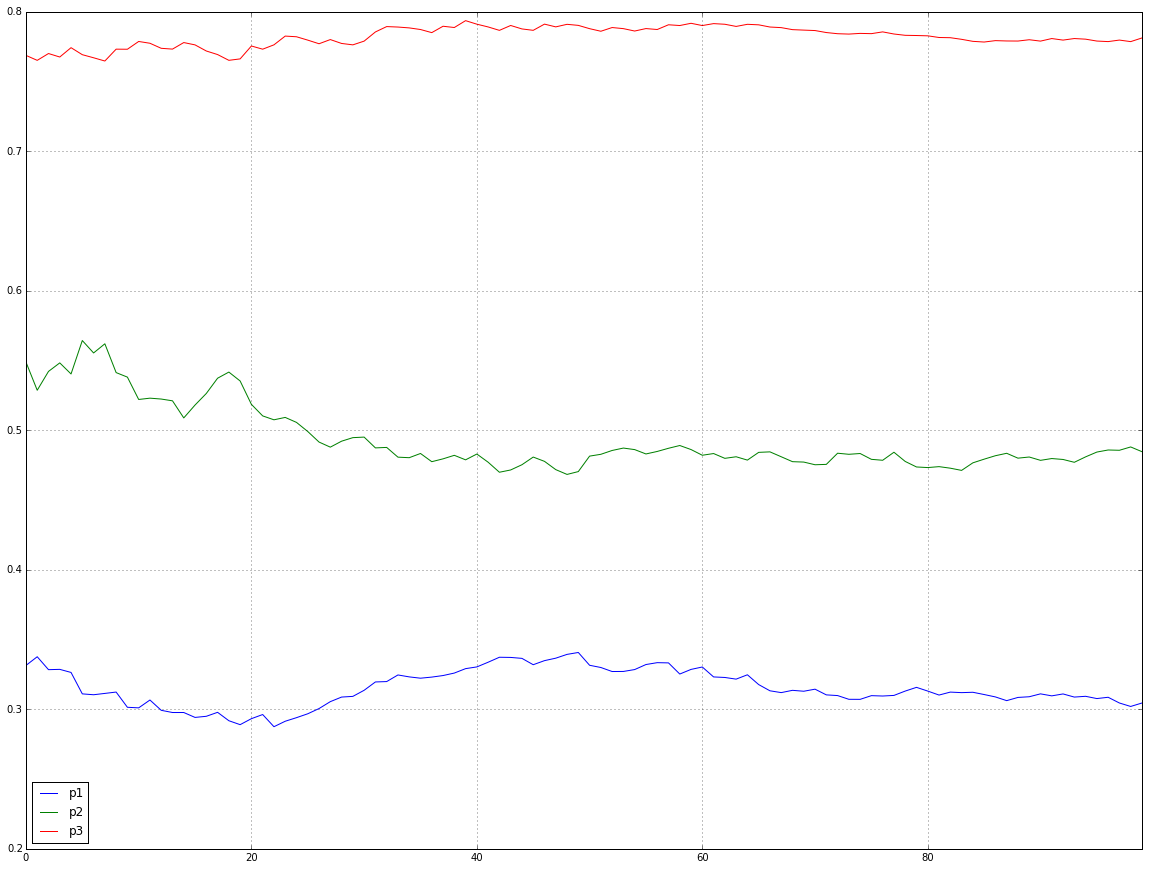

In [34]:
df.plot(figsize=[20,15])